#Network Intrusion Detection System Classifier

###Background
Network Intrusion Detections Systems (NIDS) have been used in network defense for quite some time. It is of great importance, however, to keep NIDS systems updated to identify new and evolving attack types. Researchers at the University of Queensland, Australia have produced consolidated datasets to include attacks against IoT devices and data comprising attacks against multiple test networks. Of particular interest here as well is that the data is, essentially, brand new. 

###Description
The work in this project will focus on using the provided data to create a Machine Learning model that can be used to create a NIDS in my home lab. This is something I have wanted to do for quite some time. I do not have any IoT devices running in the lab at the moment but may in the future and will aply the IoT data here as well.

###Metric
For now, the goal will be to classify traffic reflected in the dataset - bot, recon, worm, etc - with a score of 60% to allow for human intervention/triage. At the moment, I'm not too worried about DoS as I do not think anyone is DoS'ing me.

###Sources
Per the request of the researchers in using the data for academic purposes, the following papers are cited:

Sarhan, M., Layeghy, S. & Portmann, M. Towards a Standard Feature Set for Network Intrusion Detection System Datasets. Mobile Netw Appl (2021). https://doi.org/10.1007/s11036-021-01843-0

M. Sarhan, S. Layeghy, and M. Portmann, An explainable machine learning-based network intrusion detection system for enabling generalisability in securing iot networks, 2021. arXiv:2104.07183 [cs.CR] https://arxiv.org/abs/2104.07183

Sarhan M., Layeghy S., Moustafa N., Portmann M. (2021) NetFlow Datasets for Machine Learning-Based Network Intrusion Detection Systems. In: Big Data Technologies and Applications. BDTA 2020, WiCON 2020. Springer, Cham. https://doi.org/10.1007/978-3-030-72802-1_9

##Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

##Load data

In [76]:
transactions = pd.read_csv('NF-UQ-NIDS-v2_half.csv', nrows=2000)


##Explore Data

In [ ]:
#overall info
#display(transactions.info())
#transactions.describe()
transactions.dtypes
#transactions.head()

IPV4_SRC_ADDR                   object
L4_SRC_PORT                      int64
IPV4_DST_ADDR                   object
L4_DST_PORT                      int64
PROTOCOL                         int64
L7_PROTO                       float64
IN_BYTES                         int64
IN_PKTS                          int64
OUT_BYTES                        int64
OUT_PKTS                         int64
TCP_FLAGS                        int64
CLIENT_TCP_FLAGS                 int64
SERVER_TCP_FLAGS                 int64
FLOW_DURATION_MILLISECONDS       int64
DURATION_IN                      int64
DURATION_OUT                     int64
MIN_TTL                          int64
MAX_TTL                          int64
LONGEST_FLOW_PKT                 int64
SHORTEST_FLOW_PKT                int64
MIN_IP_PKT_LEN                   int64
MAX_IP_PKT_LEN                   int64
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int64
RETRANSMITTED_IN_PKTS    

In [ ]:
#average packets inbound per session
display(transactions["IN_PKTS"].mean())
display("**************************************************************")
#average packets outbound per session
display(transactions["OUT_PKTS"].mean())
display("**************************************************************")
#Unknown data
display(transactions['PROTOCOL'].value_counts())
display(transactions['L7_PROTO'].value_counts())

7.4145

'**************************************************************'

4.113

'**************************************************************'

6     1230
17     767
1        2
2        1
Name: PROTOCOL, dtype: int64

0.000      665
7.000      631
188.000    473
91.000      44
5.126       40
1.000       18
91.178      13
7.178       11
41.000      11
91.126      10
5.178       10
131.700      9
92.000       9
77.000       7
5.119        5
5.240        4
4.000        4
5.239        3
91.239       3
91.140       2
7.126        2
166.000      2
91.120       2
91.212       2
91.119       1
51.000       1
5.233        1
91.240       1
28.000       1
91.290       1
2.000        1
91.233       1
29.000       1
5.700        1
5.000        1
10.000       1
5.169        1
226.000      1
131.000      1
5.120        1
150.000      1
5.215        1
88.000       1
5.212        1
Name: L7_PROTO, dtype: int64

([<matplotlib.patches.Wedge at 0x7f4210459490>,
 [Text(-0.5359751397368545, 0.9605886994880064, '1'),
  Text(0.535975139736854, -0.9605886994880067, '0')])

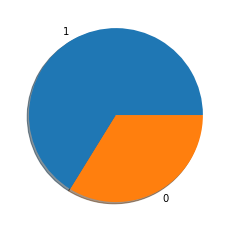

In [ ]:
#visualize Labels
#1 = malignant
#0 = benign
labels = transactions['Label'].value_counts()
pyplot.pie(labels, labels=labels.index, shadow=True)

PROTOCOL
1        2
2        1
6     1230
17     767
dtype: int64

TCP_FLAGS
0      770
2      543
16      11
17       3
18      23
19      34
20       4
22     202
23       9
24      14
25       2
26       1
27     135
28       1
30      47
31      27
211      3
214      3
219     63
222     48
223     57
dtype: int64

<BarContainer object of 4 artists>

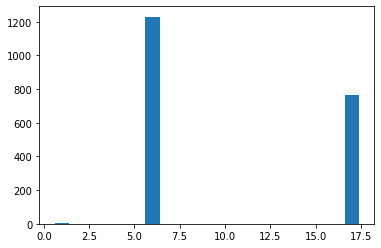

In [ ]:
#visualize PROTOCOL and TCP FLAGS 
proto = transactions['PROTOCOL'].value_counts()
#plt.pie(proto, labels=proto.index, shadow = True)

src_port = transactions['L4_SRC_PORT'].value_counts()
#plt.pie(src_port, labels=src_port.index, shadow = True)
#plt.scatter(x=transactions['L4_SRC_PORT'], y=transactions['PROTOCOL'])
tcp_flags = transactions['TCP_FLAGS'].value_counts()

#plt.scatter(x=transactions['TCP_FLAGS'], y=transactions['PROTOCOL'])
#tcp flag as 0 means not TCP
#what this shows is that when TCP flags are 0, the corresponding protocol is not TCP(UDP)

protos = transactions.groupby(['PROTOCOL']).size()
display(protos)
tcp_fls = transactions.groupby(['TCP_FLAGS']).size()
display(tcp_fls)

pyplot.bar(proto.index, proto.values, width=0.8)

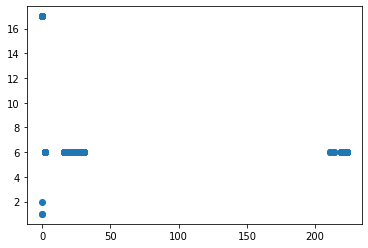

In [ ]:
pyplot.scatter(x=transactions['TCP_FLAGS'], y=transactions['PROTOCOL'])
#tcp flag as 0 means not TCP
#what this shows is that when TCP flags are 0, the corresponding protocol is not TCP(UDP)
#the 6 on the y axis has flags set the vast majority of the time

#Feature Engineering

In [56]:
#Feature 2:
for index, row in transactions.iterrows():
    if (row.DNS_QUERY_ID != 0) or (row.DNS_QUERY_TYPE != 0) or (row.DNS_TTL_ANSWER != 0):
      transactions['DNS'] = 'Y'
    else:
      transactions['DNS'] = 'N'  

In [79]:
#Label, Dataset, and Attack are self explanatory regarding need to be dropped
#Dropping src/dst addresses as I want to predict on the characteristics of the transaction, not where it was going/coming from (private addresses); model
#might predict on address which means model might not be affective in other environments
#Still not 100% certain what L7_PROTO is in this context

#all features
features = ['PROTOCOL', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'Dataset', 'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'L7_PROTO', 'FTP_COMMAND_RET_CODE', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'L4_SRC_PORT', 'L4_DST_PORT']

#dropping : ['Label', 'Dataset', 'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'L7_PROTO', 'FTP_COMMAND_RET_CODE', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'L4_SRC_PORT', 'L4_DST_PORT',]
#features = ['PROTOCOL', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
#       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
#       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
#       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
#       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
#       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
#       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
#       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
#       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
#       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
#       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
#       'DNS_TTL_ANSWER']

#features when generalizing DNS
#features = ['PROTOCOL', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
#       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
#       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
#       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
#       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
#       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
#       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
#       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
#       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
#       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
#       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS']       

#Initial Data conversion before sending to split and pipeline
#transactions['L4_SRC_PORT'] = transactions['L4_SRC_PORT'].astype(object)
#transactions['L4_DST_PORT'] = transactions['L4_DST_PORT'].astype(object)

#transactions['PROTOCOL'] = transactions['PROTOCOL'].astype(object)
#transactions['TCP_FLAGS'] = transactions['TCP_FLAGS'].astype(object)
#transactions['ICMP_TYPE'] = transactions['ICMP_TYPE'].astype(object)
#transactions['ICMP_IPV4_TYPE'] = transactions['ICMP_IPV4_TYPE'].astype(object)
#transactions['DNS_QUERY_ID'] = transactions['DNS_QUERY_ID'].astype(object)
#transactions['DNS_QUERY_TYPE'] = transactions['DNS_QUERY_TYPE'].astype(object)
#transactions['DNS_TTL_ANSWER'] = transactions['DNS_TTL_ANSWER'].astype(object)
#transactions['Label'] = transactions['Label'].astype(int)

#transactions['DNS'] = transactions['DNS'].astype(object)

#Feature 1:
#keep only 17(udp) and 6(tcp)
#keep = [17 , 6]
#transactions = transactions[transactions['PROTOCOL'].isin(keep)]


In [80]:
#splits
X = transactions.loc[:, features]
y = transactions['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2435)

In [81]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1500, 45)


,PROTOCOL,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,...,Dataset,IPV4_SRC_ADDR,IPV4_DST_ADDR,Attack,L7_PROTO,FTP_COMMAND_RET_CODE,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,L4_SRC_PORT,L4_DST_PORT
755,6,40,1,0,0,2,0,0,0,0,...,NF-CSE-CIC-IDS2018-v2,5.188.9.25,172.31.65.45,Benign,0.0,0,2,0,55992,23389
344,17,71,1,71,1,0,0,0,0,0,...,NF-ToN-IoT-v2,192.168.1.31,192.168.1.1,DoS,0.0,0,0,0,60964,53
797,17,56,2,0,0,0,4293811,1156,0,64,...,NF-BoT-IoT-v2,192.168.100.150,192.168.100.3,DDoS,188.0,0,0,0,17559,80
1090,17,68,1,100,1,0,0,0,0,0,...,NF-ToN-IoT-v2,192.168.1.35,192.168.1.1,xss,0.0,0,0,0,55694,53
1094,17,112,4,0,0,0,4293935,1032,0,64,...,NF-BoT-IoT-v2,192.168.100.147,192.168.100.3,DDoS,188.0,0,0,0,9907,80



On X test: 
X test dimensions:  (500, 45)


,PROTOCOL,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,...,Dataset,IPV4_SRC_ADDR,IPV4_DST_ADDR,Attack,L7_PROTO,FTP_COMMAND_RET_CODE,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,L4_SRC_PORT,L4_DST_PORT
356,6,2020,14,2179,11,223,0,0,0,103,...,NF-CSE-CIC-IDS2018-v2,185.129.148.224,172.31.67.4,Benign,0.000,0,219,94,33146,3389
1653,17,134,2,134,2,0,0,0,0,128,...,NF-CSE-CIC-IDS2018-v2,172.31.66.107,172.31.0.2,Benign,0.000,0,0,0,54639,53
500,17,58,1,160,1,0,0,0,0,0,...,NF-CSE-CIC-IDS2018-v2,172.31.65.121,172.31.0.2,Benign,0.000,0,0,0,64867,53
1179,6,1464,8,1873,7,30,0,0,0,103,...,NF-CSE-CIC-IDS2018-v2,185.222.56.82,172.31.66.74,Benign,0.000,0,30,26,50596,3389
1233,17,75,1,179,1,0,0,0,0,0,...,NF-CSE-CIC-IDS2018-v2,172.31.69.8,172.31.0.2,Benign,5.126,0,0,0,54387,53


In [82]:
# Y Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head()) 

# Y test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1500,)


755     0
344     1
797     1
1090    1
1094    1
Name: Label, dtype: int64


On y test: 
y test dimensions:  (500,)


356     0
1653    0
500     0
1179    0
1233    0
Name: Label, dtype: int64

#Test Pipeline

In [83]:
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(handle_unknown='ignore'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='median')),
                               ('scale_num', StandardScaler())])


preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

In [84]:
#Random Forest (accuracy at 95%)
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', RandomForestClassifier(n_estimators=500, random_state=12))])

#DecisionTree (accuracy at 94.8%)
#pipe = Pipeline(steps=[('preproc', preproc),
                       #('mdl', DecisionTreeClassifier())])

#LogisticRegression (accuracy with various penalties/solvers/etc 81%-89%)
#pipe = Pipeline(steps=[('preproc', preproc),
                       #('mdl', LogisticRegression(penalty='l2', solver='sag', random_state=1))])

#SupportVectorMachine (accuracy 89.6%)
#pipe = Pipeline(steps=[('preproc', preproc),
                      #('mdl', SVC(kernel='linear'))])   

#GBM (accuracy 93%) **GOING WITH THIS MODEL AS IT SEEMS TO BE IN THE MIDDLE**
#pipe = Pipeline(steps=[('preproc', preproc),
                  #('mdl', GradientBoostingClassifier())])                    

with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb722f52710>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb722ed7390>)])),
                ('mdl',
                 RandomForestClassifier(n_estimators=500, random_state=12))])

In [85]:
pipe.fit(X_train, y_train)
#pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.992


Best Threshold=1.000000, Net Gain=0.982


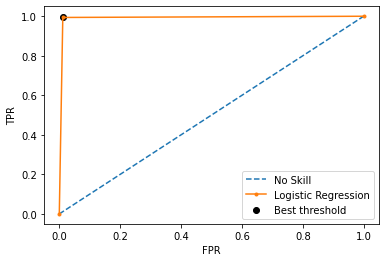

In [86]:
y_proba = pipe.predict_proba(X_test)

y_proba = y_proba[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

net_gain = tpr - fpr
ix = np.argmax(net_gain)
print('Best Threshold=%f, Net Gain=%.3f' % (thresholds[ix], net_gain[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic Regression')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best threshold')

# axis labels
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.legend()

pyplot.show()


In [87]:
cm = pd.DataFrame()
cm['tpr'] = tpr
cm['fpr'] = fpr
cm['thresholds'] = thresholds
cm['tpr-fpr'] = tpr - fpr
cm['value'] = cm['tpr'] * 10 - cm['fpr'] * 1000
cm.sort_values('value', ascending=False).iloc[0, 2]

2

#Cross-validation with hyperparameter tuning

In [88]:
#Gradiant Boosting
#param_grid = {
#    'mdl__learning_rate': (0.01, 0.1, 1, 10),
#    'mdl__max_leaf_nodes': (3, 10, 30)}
#grid_search = GridSearchCV(pipe, param_grid = param_grid, cv = 5, n_jobs=2)

#LogisticRegression 
#tuning_grid = {'mdl__l1_ratio' : np.linspace(0,1,5),
#               'mdl__C': np.logspace(-1, 6, 3) }
#grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 10, return_train_score=True)
#tuning_grid


#RFC
maxdepth_grid = [ 6, 8, 10, 12, 15, 20]
param_grid = [
   {'mdl__max_depth': maxdepth_grid },
]
grid_search = GridSearchCV(pipe, cv=5, param_grid=param_grid, return_train_score=True)

In [89]:
#fit
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb722f52710>),
                                                                        ('num_pipe',
                                             

In [90]:
#Find the best performing model parameters and their values
print(grid_search.best_score_)
grid_search.best_params_

0.9953333333333333


{'mdl__max_depth': 12}

In [91]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb722e46290>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale_num',
        

#Variable Importance

In [92]:
print(grid_search.classes_)
print("0 is benign, 1 is malignant")

[0 1]
0 is benign, 1 is malignant


In [93]:
#GBM
#vip = grid_search.best_estimator_['mdl'].feature_importances_
#vip

#LogReg
#vip = grid_search.best_estimator_['mdl'].coef_[0]
#vip

#RFC
vip = grid_search.best_estimator_['mdl'].feature_importances_
vip

array([5.36884055e-05, 2.79992399e-03, 2.33142775e-03, 1.93631812e-03,
       3.48664915e-03, 8.86254780e-04, 4.16961023e-04, 3.16284678e-04,
       2.70988186e-04, 8.89270252e-05, 1.39166788e-03, 3.30053790e-04,
       5.10473006e-04, 1.13833224e-05, 3.80709930e-05, 1.57841739e-03,
       1.46482822e-03, 4.09451057e-04, 2.19621874e-04, 9.48351415e-05,
       1.46997644e-03, 1.79700953e-03, 5.51714445e-04, 7.31256040e-04,
       4.90347394e-05, 9.66643403e-06, 8.65612616e-07, 4.10490897e-05,
       2.91649065e-05, 4.54781661e-05, 4.97139698e-06, 1.42056702e-04,
       5.93786292e-07, 1.08562416e-04, 1.52323245e-05, 1.83087899e-06,
       3.94859813e-07, 7.03207420e-06, 0.00000000e+00, 2.33126091e-05,
       8.31600311e-04, 1.97701567e-05, 2.56934130e-06, 1.92809019e-06,
       5.57947209e-05, 4.10179170e-05, 5.03780480e-05, 3.40027938e-06,
       3.77144051e-05, 1.03246606e-04, 1.35385517e-04, 3.64950243e-07,
       6.05791579e-06, 8.71528318e-05, 1.28422151e-08, 1.85479586e-05,
      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


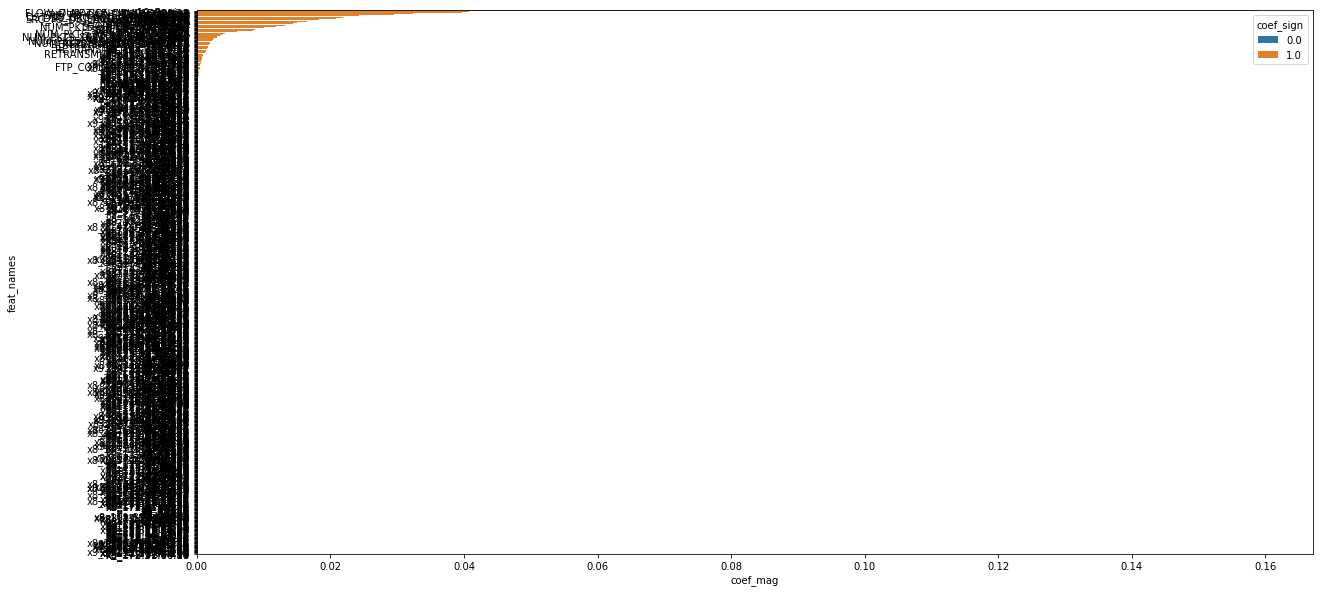

In [94]:
# #get names in correct preproc order
cat_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

# #create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

# #get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

# #sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
pyplot.figure(figsize = (20,10))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

#Performance metrics on test data

In [95]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.99      0.99      0.99       326

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



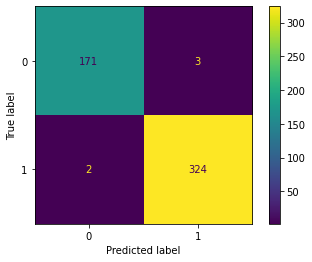

In [96]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search.classes_)
disp.plot()

pyplot.show()

Average cost of total loss of asset, including data = 10,000 dollars<br> 
Average intervention cost = 500 dollars <br>
Intervention is successful (prevent attack from spreading) 95% of the time

##GBM Cost/Benefit

149 Bening actual Benign<br>
6 Benign predicted as Attack<br>
22 Attacks predicted as Bening<br>
323 Attacks predicted as attack<br>

6 benign predicted as attack = 3,000 dollars<br>
95% of 323 attacks stopped so 16.15 attacks successful = 169,575 dollars<br>
95% of 323 attacks id'd correctly = 306.9<br>
306.9 x 10,500 = 3,222,450 dollars savings<br>

##LogisticRegression Cost/Benefit
139 Bening actual Benign<br>
16 Benign predicted as Attack<br>
54 Attacks predicted as Bening<br>
291 Attacks predicted as attack<br>

16 benign predicted as attack = 8,000 dollars<br>
95% of 291 attacks stopped so 14.55 attacks successful = 152,775 dollars<br>
95% of 291 atacks id'd correctly = 276.45<br>
276.45 x 10,500 = 2,902,725 dollars savings<br>

##RandomForest Cost/Benefit
149 Bening actual Benign<br>
6 Benign predicted as Attack<br>
17 Attacks predicted as Bening<br>
328 Attacks predicted as attack<br>

6 benign predicted as attack = 3,000 dollars<br>
95% of 328 attacks stopped so 16.4 successful = 172,200 dollars<br>
95% of 328 attacks id'd correctly = 311.16<br>
311.16 x 10,500 = 3,267,180 dollars savings<br>

##Feature Engineering Review

1. With both features and dropped rows:
TN = 145, TP = 328, FP = 9, FN = 17; Accuracy = 95%

2. With keeping just TCP/UP Protocols and dropping rows:
TN = 149, TP = 328, FP = 6, FN = 17; Accuracy = 95%

3. With generalizing DNS:
TN = 153, TP = 320, FP = 21, FN = 6; Accuracy = 95%

4. With no features added/removed:
TN = 171, TP = 324, FP = 3, FN = 2; Accuracy = 99% (wow)